In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part1.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own group**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Question 0: Basic Time Series Modeling

We will introduce a few basic modeling techniques using temporally correlated data that you are free to adapt or improve throughout your modeling process if you wish. Answer these questions in their respective cells below.

### Question 0a
Suppose $\tilde{x} = [1, x_{t}]$ represents the input to a machine learning function $f_\theta: \mathbb{R}^{2} \rightarrow \mathbb{R}$, and we wish to predict $x_{t + 1}$ such that $f_\theta(\tilde{x}) \approx x_{t+1}$. You may assume that $t = 0$ corresponds to the start of time. 

<!-- BEGIN QUESTION -->

i) Is this an example of supervised or unsupervised learning?
<!--
BEGIN QUESTION
name: q0ai
points: 2
manual: True
-->

This is supervised learning, as we get the result of what we are trying to predict right away.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

ii) Write the function $x_{t+1}$ explicitly in terms of the model parameters $\theta = [\theta_0, \theta_1]$ and $x_t$ assuming $f$ represents a linear model.
<!--
BEGIN QUESTION
name: q0aii
points: 2
manual: True
-->

$x_{t+1}=\theta_0+\theta_1{x_t}$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iii) Suppose we obtain an optimal $\hat{\theta} = [\hat{\theta}_0, \hat{\theta}_1]$. Derive $x_{t+1}$ in terms of $x_0$, $\hat{\theta}_0$ and $\hat{\theta}_1$.

<!--
BEGIN QUESTION
name: q0aiii
points: 4
manual: True
-->

$x_1=\theta_0+\theta_1x_0$, $x_2=\theta_0+\theta_1x_1=\theta_0+\theta_0\theta_1+\theta_0\theta_1^2x_0\newline$
_Thus:_
$x_{t+1}=\hat{\theta}_1^{t+1}x_0+\sum_{n=0}^{t}\hat{\theta}_0\hat{\theta}_1^n$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

iv) Suppose we add $k - 1$ more features such that our feature vector $\tilde{x}$ contains $k$ timesteps of past and current data. Describe how we could select an appropriate $k$.

<!--
BEGIN QUESTION
name: q0aiv
points: 2
manual: True
-->

We can use cross-validation (separating the test error into sections and testing different combinations of training data and validation data on our model) to estimate test error and training error. Then, we try various numbers of features and search for the number of features that minimizes the difference between test error and training error. If this is too resource-intensive, we could simplify this process by simply using the first 𝑘 features in the data table to find a 𝑘 that minimizes the difference between test error and training error.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 1: Data Cleaning

### Question 1a

Investigate the number of missing or null values in `cases` and `vaccinations`. Which one column contains the *most* null values from both of these tables?

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [3]:
most_null_value_col = vaccinations.isna().sum().sort_values(ascending = False).index[0]
most_null_value_col

'People_Partially_Vaccinated'

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [5]:
vaccinations = vaccinations.fillna(0)
cases = cases.fillna(0)

In [6]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c

Add a column to `cases` named `median_increase` that describes the median daily increase in the number of cases over the time period January 23, 2020 to September 12, 2021. In other words, calculate the increase in cases day-to-day from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so on; then, find the median of the number of increase in cases over that time period for all counties.

*Hint*: Try not to use a `for` loop.

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [7]:
first_index = cases.columns.get_loc('1/23/20')
second_index = cases.columns.get_loc('9/12/21')
cases['median_increase'] = cases.iloc[:, first_index: second_index + 1].diff(axis = 1).fillna(0).median(axis = 1)

In [8]:
cases['median_increase'].sum() == 29692

True

In [9]:
grader.check("q1c")

q1c results: All test cases passed!

### Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 2
-->

In [10]:
counties["FIPS"] = counties["STATE"] * 1000 + counties["COUNTY"]
counties

SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME            CTYNAME  \
0         40       3         6      1       0  Alabama            Alabama   
1         50       3         6      1       1  Alabama     Autauga County   
2         50       3         6      1       3  Alabama     Baldwin County   
3         50       3         6      1       5  Alabama     Barbour County   
4         50       3         6      1       7  Alabama        Bibb County   
...      ...     ...       ...    ...     ...      ...                ...   
3189      50       4         8     56      37  Wyoming  Sweetwater County   
3190      50       4         8     56      39  Wyoming       Teton County   
3191      50       4         8     56      41  Wyoming       Uinta County   
3192      50       4         8     56      43  Wyoming    Washakie County   
3193      50       4         8     56      45  Wyoming      Weston County   

     CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  ...  POPESTIMATE2013  \
0          4779736            4780118          4785514  ...          4831586   
1            54571              54582            54761  ...            54747   
2           182265             182263           183121  ...           194978   
3            27457              27454            27325  ...            26946   
4            22915              22904            22858  ...            22510   
...            ...                ...              ...  ...              ...   
3189         43806              43806            43580  ...            45189   
3190         21294              21298            21298  ...            22335   
3191         21118              21121            21090  ...            20969   
3192          8533               8528             8531  ...             8417   
3193          7208               7208             7198  ...             7132   

      POPESTIMATE2014  POPESTIMATE2015  POPESTIMATE2016  POPESTIMATE2017  \
0             4843737          4854803          4866824          4877989   
1               54922            54903            55302            55448   
2              199306           203101           207787           212737   
3               26768            26300            25828            25169   
4               22541            22553            22590            22532   
...               ...              ...              ...              ...   
3189            44996            44780            44319            43663   
3190            22801            23083            23255            23383   
3191            20835            20777            20711            20449   
3192             8277             8282             8180             8013   
3193             7134             7202             7228             6962   

      POPESTIMATE2018  POPESTIMATE2019  POPESTIMATE042020  POPESTIMATE2020  \
0             4891628          4907965            4920706          4921532   
1               55533            55769              56130            56145   
2              218071           223565             227989           229287   
3               24887            24657              24652            24589   
4               22300            22313              22199            22136   
...               ...              ...                ...              ...   
3189            43188            42917              42717            42673   
3190            23261            23385              23453            23497   
3191            20299            20196              20169            20215   
3192             7886             7824               7756             7760   
3193             6895             6880               6752             6743   

       FIPS  
0      1000  
1      1001  
2      1003  
3      1005  
4      1007  
...     ...  
3189  56037  
3190  56039  
3191  56041  
3192  56043  
3193  56045  

[3194 rows x 22 columns]

In [11]:
grader.check("q1d")

q1d results: All test cases passed!

### Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 2
-->

In [12]:
county_data = counties.join(cases.set_index("FIPS"), on = "FIPS", how = "inner").join(
    mask_use.set_index("COUNTYFP"), on = "FIPS", how = 'inner')
county_data['COUNTYFP'] = county_data["FIPS"]
county_data

SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME            CTYNAME  \
1         50       3         6      1       1  Alabama     Autauga County   
2         50       3         6      1       3  Alabama     Baldwin County   
3         50       3         6      1       5  Alabama     Barbour County   
4         50       3         6      1       7  Alabama        Bibb County   
5         50       3         6      1       9  Alabama      Blount County   
...      ...     ...       ...    ...     ...      ...                ...   
3189      50       4         8     56      37  Wyoming  Sweetwater County   
3190      50       4         8     56      39  Wyoming       Teton County   
3191      50       4         8     56      41  Wyoming       Uinta County   
3192      50       4         8     56      43  Wyoming    Washakie County   
3193      50       4         8     56      45  Wyoming      Weston County   

     CENSUS2010POP  ESTIMATESBASE2010  POPESTIMATE2010  ...  9/10/21  9/11/21  \
1            54571              54582            54761  ...     9207     9246   
2           182265             182263           183121  ...    34726    34872   
3            27457              27454            27325  ...     3260     3282   
4            22915              22904            22858  ...     3752     3778   
5            57322              57322            57372  ...     9095     9161   
...            ...                ...              ...  ...      ...      ...   
3189         43806              43806            43580  ...     6111     6111   
3190         21294              21298            21298  ...     4611     4611   
3191         21118              21121            21090  ...     3204     3204   
3192          8533               8528             8531  ...     1120     1120   
3193          7208               7208             7198  ...      829      829   

      9/12/21  median_increase  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS  \
1        9287             10.0  0.053   0.074      0.134       0.295   0.444   
2       34950             24.0  0.083   0.059      0.098       0.323   0.436   
3        3295              3.0  0.067   0.121      0.120       0.201   0.491   
4        3795              3.0  0.020   0.034      0.096       0.278   0.572   
5        9176              8.0  0.053   0.114      0.180       0.194   0.459   
...       ...              ...    ...     ...        ...         ...     ...   
3189     6111              3.0  0.061   0.295      0.230       0.146   0.268   
3190     4611              2.0  0.095   0.157      0.160       0.247   0.340   
3191     3204              1.0  0.098   0.278      0.154       0.207   0.264   
3192     1120              0.0  0.204   0.155      0.069       0.285   0.287   
3193      829              0.0  0.142   0.129      0.148       0.207   0.374   

      COUNTYFP  
1         1001  
2         1003  
3         1005  
4         1007  
5         1009  
...        ...  
3189     56037  
3190     56039  
3191     56041  
3192     56043  
3193     56045  

[3141 rows x 639 columns]

In [13]:
county_data['POPESTIMATE2020'].sum() == 329474777

True

In [14]:
grader.check("q1e")

q1e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 1f

Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`). Remark on any inconsistencies and propose a solution. 
<!--
BEGIN QUESTION
name: q1f
points: 2
manual: True
-->

On the counties dataframe, each county as well as each state are included. Hence the population estimate contains the actual total population twice. Hence we need to divide the number by two after we group by the state name.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 2: Guided EDA

<!-- BEGIN QUESTION -->

### Question 2a

Create a visualization that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021. Make sure to include the name of state in which each county is located since county names are not necessarily unique.
<!--
BEGIN QUESTION
name: q2a
points: 3
manual: True
-->

''

<Figure size 432x288 with 0 Axes>

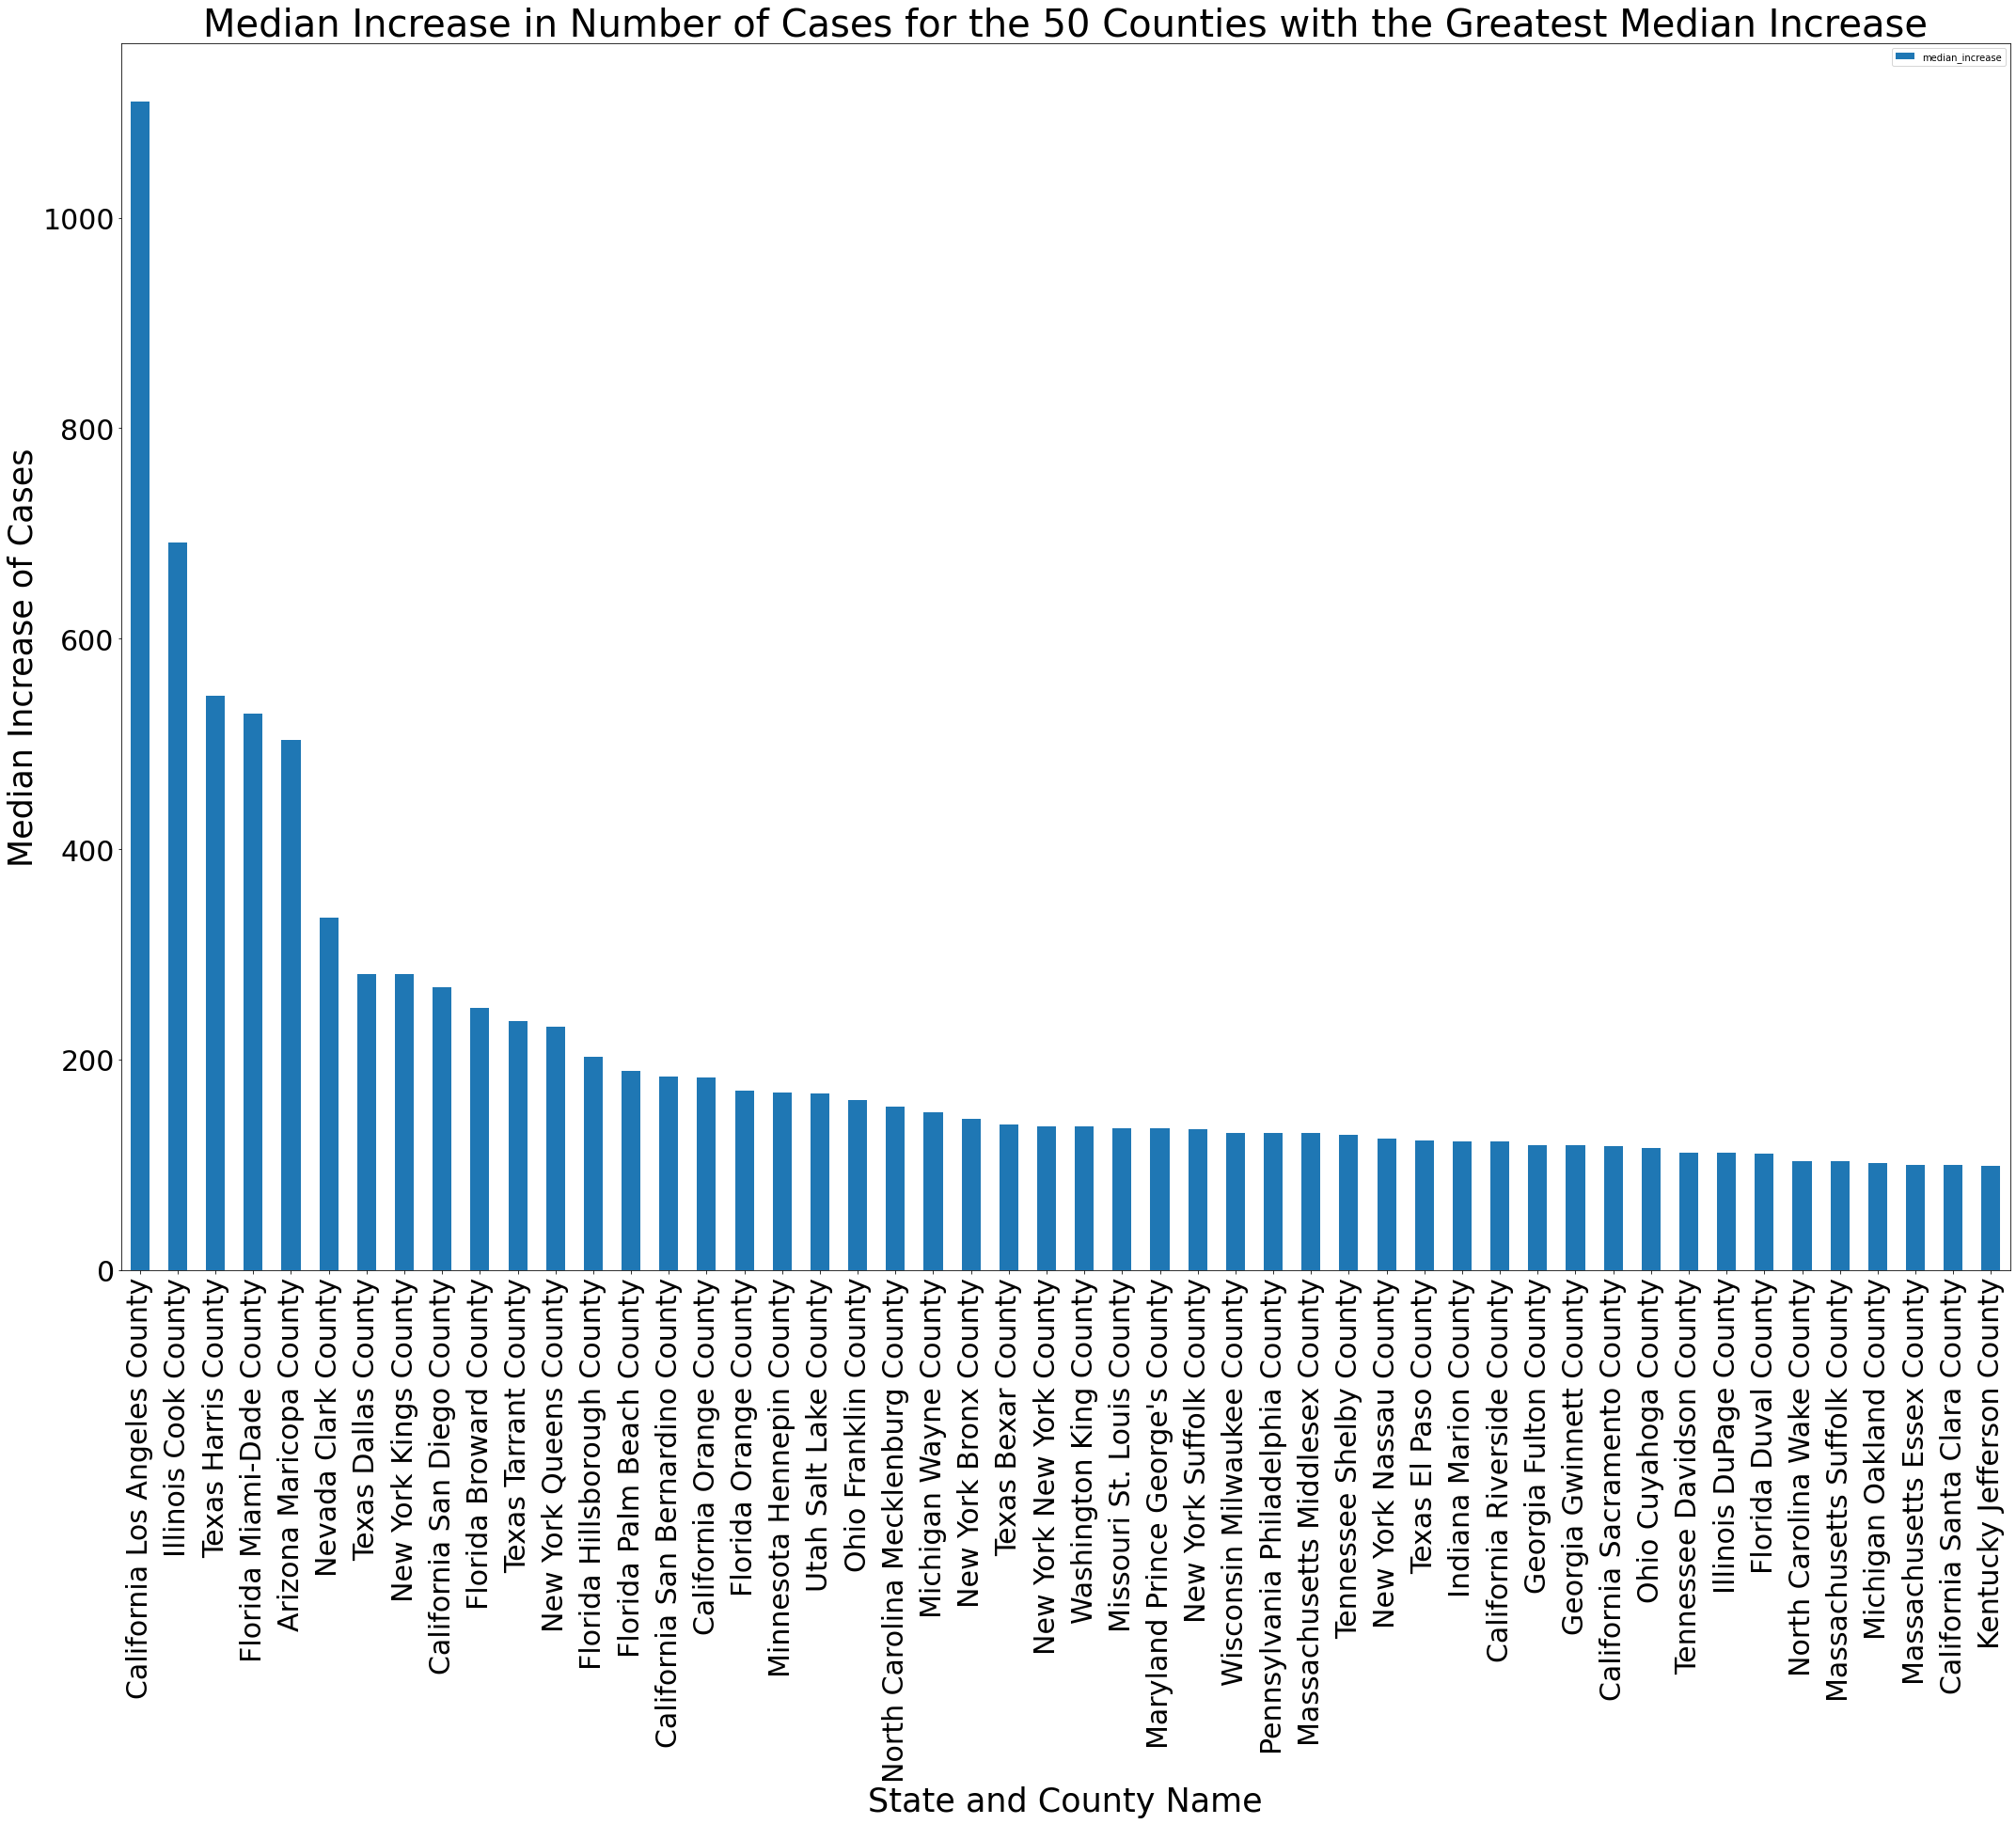

In [15]:
plt.figure()
want = county_data.sort_values('median_increase', ascending = False).iloc[:50, :]
want = want[["STNAME", 'CTYNAME', 'median_increase']]
want['State and County Name'] = want["STNAME"] + ' ' + want['CTYNAME']
want.plot.bar(x = 'State and County Name', y = 'median_increase', figsize=(36,24))
plt.xticks(size = 30)
plt.yticks(size=30)
plt.xlabel('State and County Name', size = 35)
plt.ylabel('Median Increase of Cases', size = 35)
plt.title('Median Increase in Number of Cases for the 50 Counties with the Greatest Median Increase', size = 40)
;

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2b

Create a visualization that shows the overall county-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. For all questions that reference population, use the population estimates from 2020.
<!--
BEGIN QUESTION
name: q2b
points: 4
manual: True
-->

''

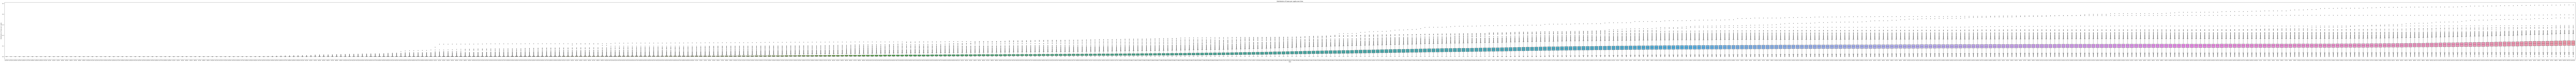

In [16]:
per_capita_cases = county_data.loc[:,'1/22/20':'9/12/21'].div(county_data['POPESTIMATE2020'], axis=0)
per_capita_cases = per_capita_cases.transpose()
combined_per_capita_cases = per_capita_cases.stack().to_frame()
combined_per_capita_cases = combined_per_capita_cases.reset_index(level=[1])

plt.figure(figsize=(440, 10), dpi=80)
sns.boxplot(x=combined_per_capita_cases.index, y = 0, data = combined_per_capita_cases)
plt.title('Distribution of Cases per capita over time')
plt.xlabel('Date')
plt.ylabel('Distribution of Cases per capita')
# Double click the visualization to zoom.
;

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2c

Create a visualization that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

<!--
BEGIN QUESTION
name: q2c
points: 3
manual: True
-->

''

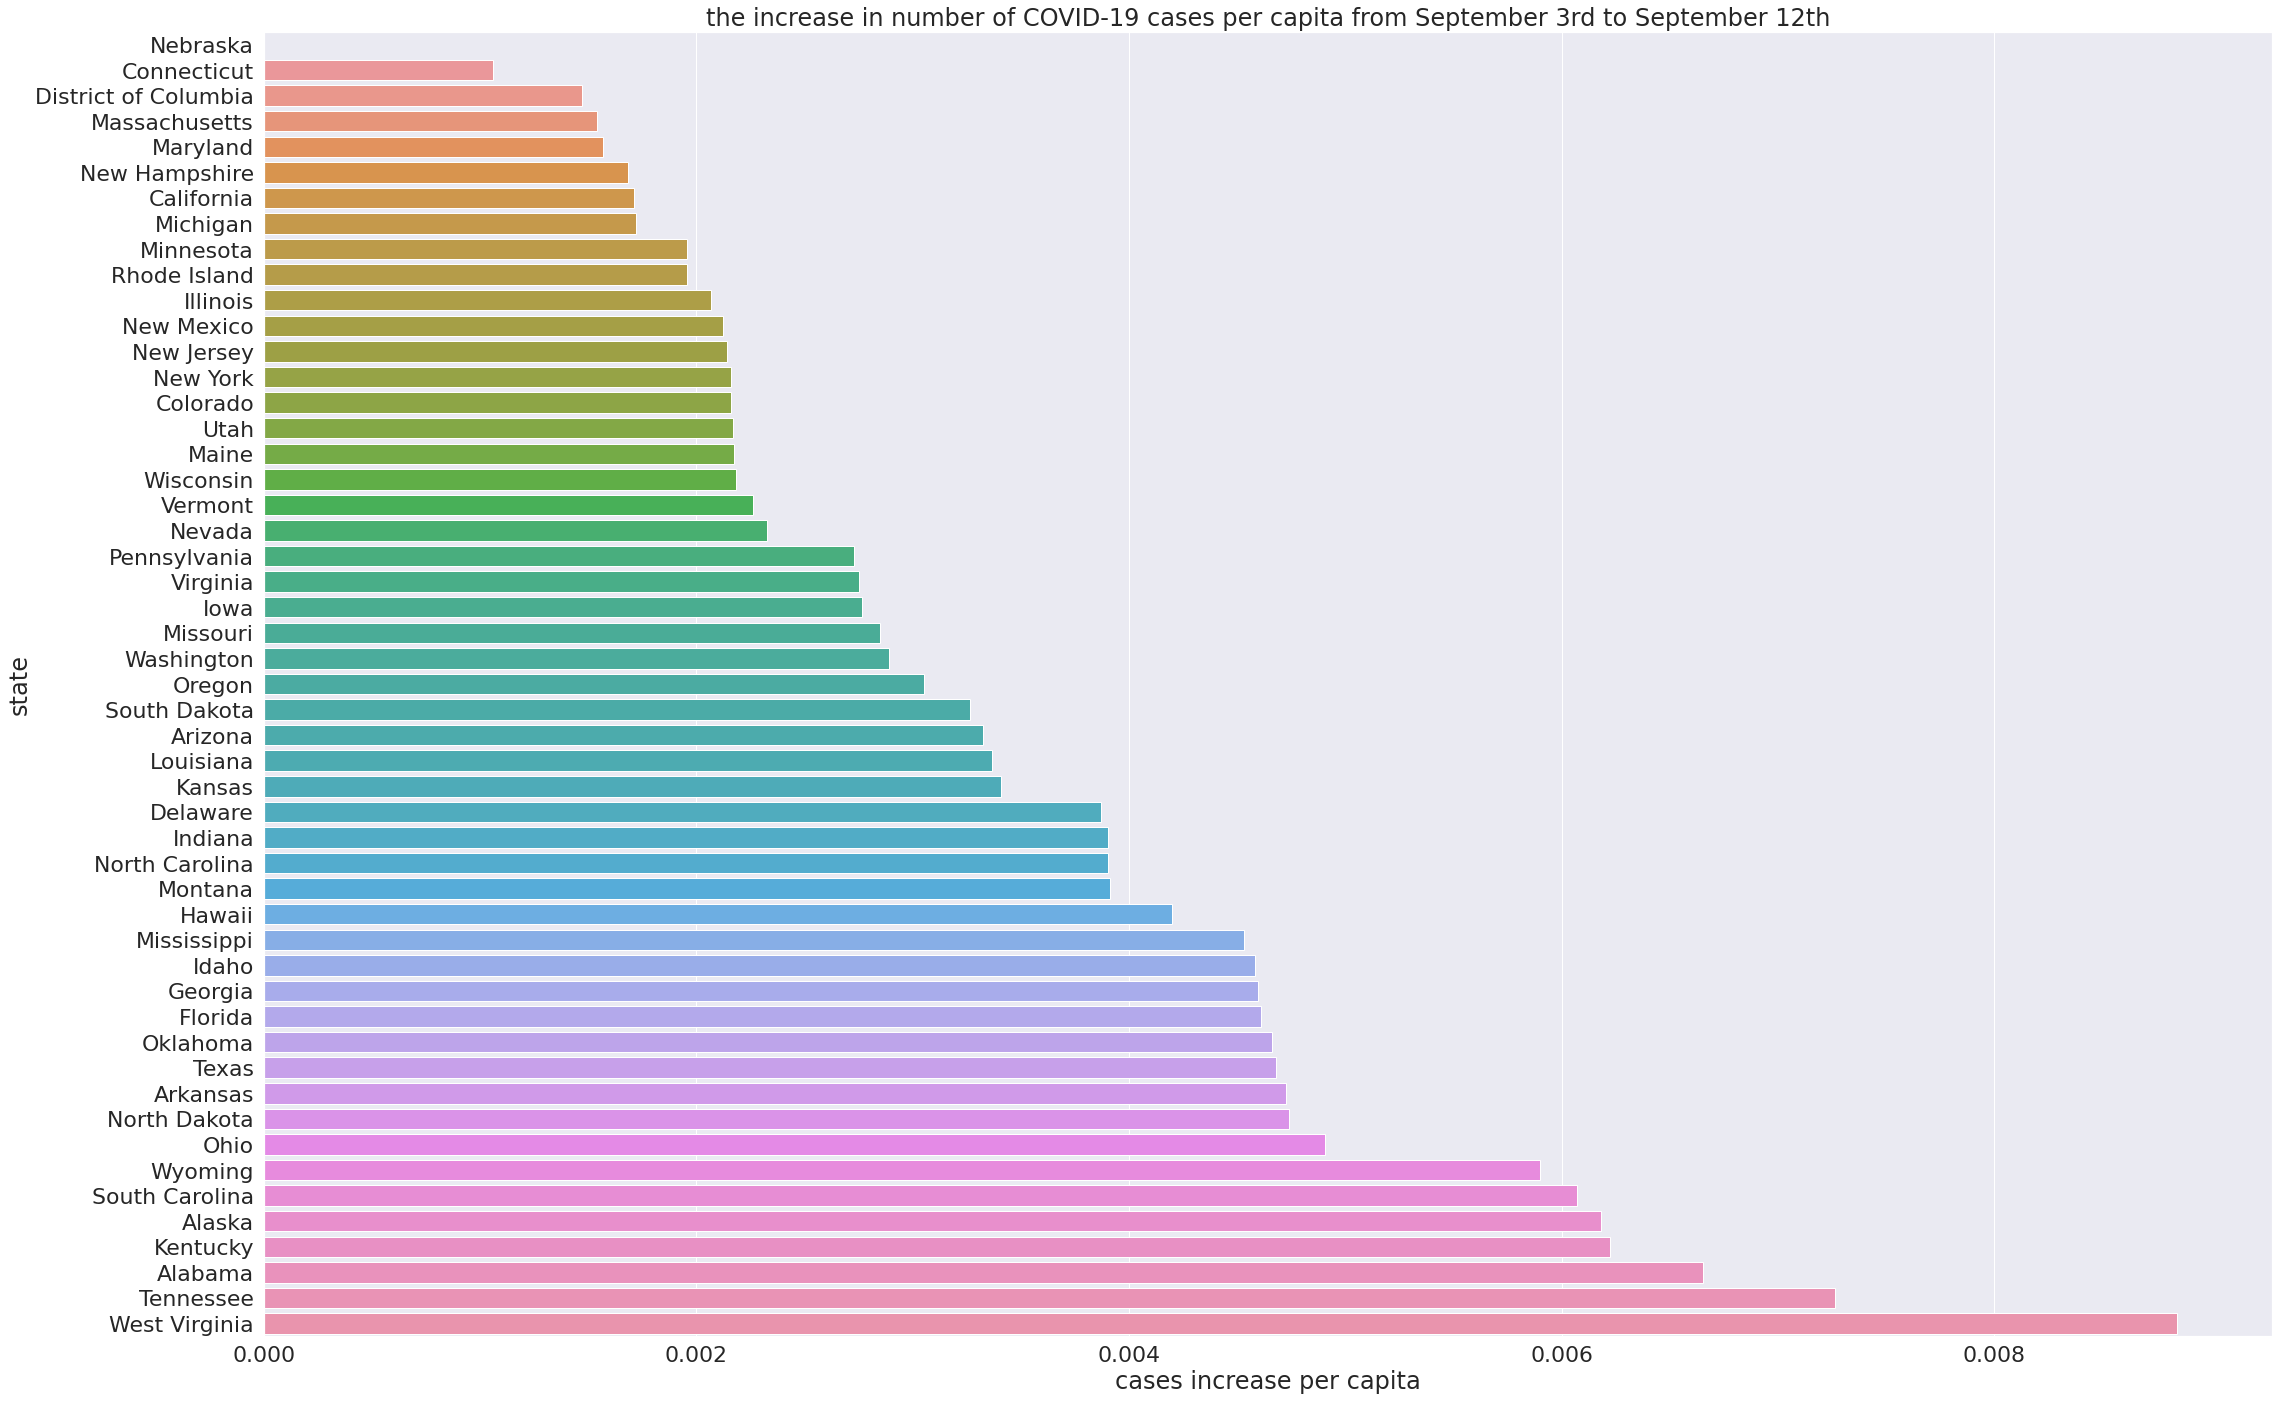

In [17]:
county_states=county_data.groupby("STNAME").sum()
b=list([county_states.columns.get_loc('POPESTIMATE2020'),county_states.columns.get_loc('9/3/21'),county_states.columns.get_loc('9/12/21')])
states_pop = county_states.iloc[:,b]["POPESTIMATE2020"].values
temp=county_states.iloc[:,b].drop(columns="POPESTIMATE2020").diff(axis=1).sum(axis=1)
df_visualization = pd.DataFrame(data={'state': temp.index, 'cases increase per capita': temp.values/states_pop}).sort_values("cases increase per capita")
sns.set(font_scale=2)
plt.figure(figsize=(36,24))
sns.barplot(y="state", x="cases increase per capita", data=df_visualization);
plt.title("the increase in number of COVID-19 cases per capita from September 3rd to September 12th")
;

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d

Create a plot using a technique of your choice that visualizes the relationship between:

a) the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

b) the frequency of never, rarely or sometimes wearing a mask in the respective counties

*Hint*: You may find a description of the data [here](https://github.com/CSSEGISandData/COVID-19/blob/846fa9458cc2a8904d2492d14d3e6b4f399ec027/csse_covid_19_data/csse_covid_19_time_series/README.md).

<!--
BEGIN QUESTION
name: q2d
points: 3
manual: True
-->

''

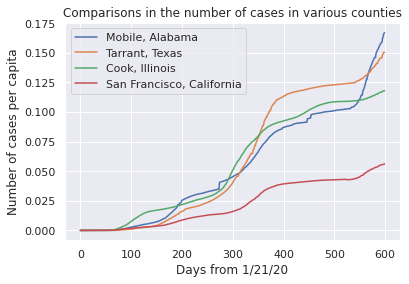

In [18]:
def get_county_infection(county, state):
    result = county_data[county_data['STNAME']==state]
    county_found = result[[county in i for i in result['CTYNAME']]]
    return county_found.iloc[:,32:632].to_numpy()[0]/county_found['POPESTIMATE2020'].iloc[0]
def get_county_badhabits(county, state):
    result = county_data[county_data['STNAME']==state]
    result = result[[county in i for i in result['CTYNAME']]]
    return (result['NEVER']+result['RARELY']+result['SOMETIMES']).iloc[0]

sns.set()
sns.lineplot(x=range(get_county_infection('Mobile', 'Alabama').size), y=get_county_infection('Mobile', 'Alabama'), label = 'Mobile, Alabama')
sns.lineplot(x=range(get_county_infection('Tarrant', 'Texas').size), y=get_county_infection('Tarrant', 'Texas'), label = 'Tarrant, Texas')
sns.lineplot(x=range(get_county_infection('Tarrant', 'Texas').size), y=get_county_infection('Cook', 'Illinois'), label = 'Cook, Illinois')
sns.lineplot(x=range(get_county_infection('Tarrant', 'Texas').size), y=get_county_infection('San Francisco', 'California'), label = 'San Francisco, California')
plt.title('Comparisons in the number of cases in various counties')
plt.ylabel('Number of cases per capita')
plt.xlabel('Days from 1/21/20')
;

''

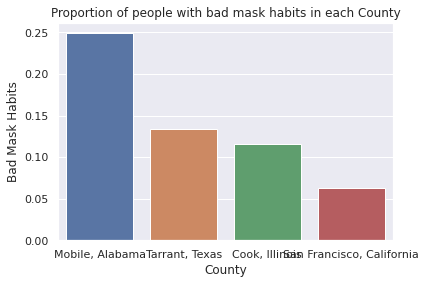

In [19]:
data = pd.DataFrame()
data = data.append({'County':'Mobile, Alabama', 'Bad Mask Habits':get_county_badhabits('Mobile','Alabama')}, ignore_index=True)
data = data.append({'County':'Tarrant, Texas', 'Bad Mask Habits':get_county_badhabits('Tarrant','Texas')}, ignore_index=True)
data = data.append({'County':'Cook, Illinois', 'Bad Mask Habits':get_county_badhabits('Cook','Illinois')}, ignore_index=True)
data = data.append({'County':'San Francisco, California', 'Bad Mask Habits':get_county_badhabits('San Francisco', 'California')}, ignore_index=True)
sns.barplot(x='County', y = 'Bad Mask Habits', data = data)
plt.title('Proportion of people with bad mask habits in each County')
sns.set()
;

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e

Visualize and describe the spatial relationship between the location and the following quantities over the continguous United States:

a) the number of most recent COVID-19 cases per capita on September 12, 2021

b) the frequency of never, rarely or sometimes wearing a mask

*Hint*: Use `plotly` to generate a heatmap on a geographical plot of the United States!

<!--
BEGIN QUESTION
name: q2e
points: 5
manual: True
-->

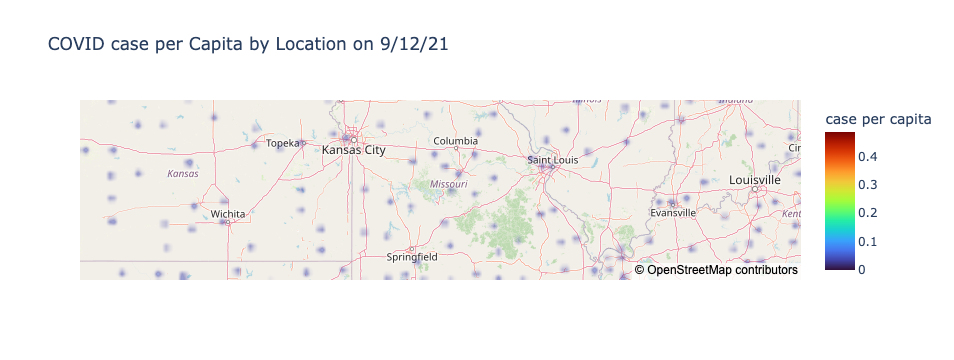

In [20]:
county_data_drop = county_data[county_data["STNAME"]!= "Alaska"]
county_data_drop = county_data[county_data["STNAME"]!= "Hawaii"] 
fips = county_data_drop.groupby("CTYNAME").agg("max")["COUNTYFP"].values
count_of_county = county_data_drop.groupby("CTYNAME").count().iloc[:,1].values
county_grouped = county_data_drop.groupby("CTYNAME").sum().loc[:,("9/12/21", "POPESTIMATE2020","ALWAYS")]
county_grouped["frequency"]= ((count_of_county - county_grouped["ALWAYS"])/count_of_county)
county_grouped = county_grouped.reset_index()
county_grouped["case per capita"] = county_grouped["9/12/21"]/county_grouped["POPESTIMATE2020"] 
county_grouped["FIPS"] = fips
small_cases = cases[cases["Province_State"] != "Alaska"]
small_cases  = small_cases[cases["Province_State"] != "Hawaii"]
small_cases = small_cases.loc[:,("FIPS","Lat","Long_")]
county_grouped = county_grouped.merge(small_cases, how = "left",left_on='FIPS', right_on='FIPS')

fig = px.density_mapbox(county_grouped, lat='Lat', lon='Long_', z="case per capita", radius=6,color_continuous_scale= "turbo",
                        hover_name="CTYNAME",zoom= 5,opacity = 0.5,
                        mapbox_style="open-street-map",title = "COVID case per Capita by Location on 9/12/21")
fig.show()

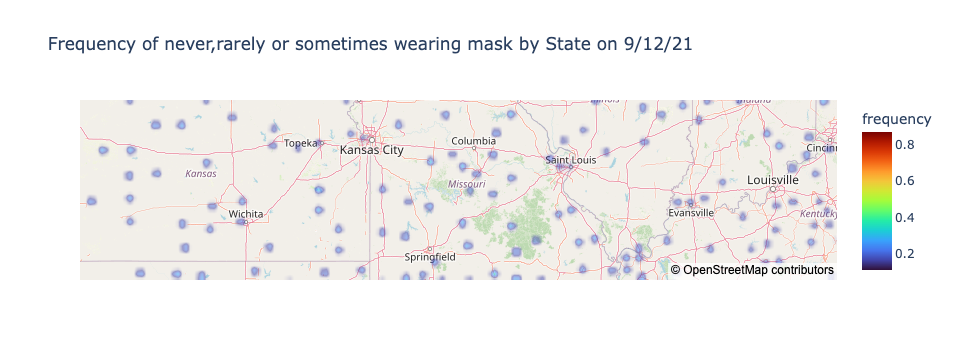

In [21]:
fig = px.density_mapbox(county_grouped, lat='Lat', lon='Long_', z="frequency", radius=6,color_continuous_scale= "turbo",
                        hover_name="CTYNAME", zoom= 5,opacity = 0.5,
                        mapbox_style="open-street-map",title = "Frequency of never,rarely or sometimes wearing mask by State on 9/12/21")
fig.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2f

Describe and interpret the relationships in the plots above. What conclusions can be drawn about the COVID-19 dataset from these plots?

<!--
BEGIN QUESTION
name: q2f
points: 3
manual: True
-->

2a starts with displaying the top 50 counties with the highest median increase. 2b plots the distribution of cases per capita over time. From it, we can observe a steady increase of covid cases per capita as time progresses. 2c then picks out a certain time period, September 3rd to September 12th, and plots the increase in number of cases per capita across each state. 2d then investigates specific counties in terms of their cases per capita and mask habits. This provides us with some insights on the relationship between mask use and spread. For San Francisco, a county with relatively good mask habits has a comparatively lower number of cases per capita. And lastly, from 2e, this relationship is explored on a bigger scale. And the same conclusion can be drawn as with the previous plot, good mask habits tend to lead to lower cases per capita and bad mask habits tend to lead to higher cases per capita.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 3: Guided Unsupervised Exploration


<!-- BEGIN QUESTION -->

### Question 3a

Using SVD, decompose the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data.

*Hint*: The matrix $X$ should have rows that describe location.

<!--
BEGIN QUESTION
name: q3a
points: 3
manual: True
-->

In [22]:
latest_cases = county_data.groupby("STNAME").sum()['9/12/21'].values
possibleStates = counties.groupby("STNAME").max()['POPESTIMATE2020'].index.to_list()
total_pop2020 = counties.loc[counties["STNAME"].isin(possibleStates)].groupby("STNAME").max()['POPESTIMATE2020'].values
PFV = vaccinations.loc[vaccinations["Province_State"].isin(possibleStates)][vaccinations['Date'] == '2021-09-26']['People_Fully_Vaccinated'].values
PPV = vaccinations.loc[vaccinations["Province_State"].isin(possibleStates)][vaccinations['Date'] == '2021-09-26']['People_Partially_Vaccinated'].values
Grouped = county_data.groupby("STNAME").mean()
Grouped["Proportion of Fully Vaccinated"] = PFV / total_pop2020
Grouped["Proportion of Partially Vaccinated"] = PPV / total_pop2020
Grouped["Cases per Capita"] = latest_cases / total_pop2020
Grouped = Grouped[["Proportion of Fully Vaccinated", "Proportion of Partially Vaccinated", "Cases per Capita",
                   "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]]
X = (Grouped - Grouped.mean()) / Grouped.std()
u, s, vt =  np.linalg.svd(X, full_matrices = False)
X.head(5)

Proportion of Fully Vaccinated  \
STNAME                                       
Alabama                          -1.444506   
Alaska                           -0.424058   
Arizona                          -0.551438   
Arkansas                         -1.094012   
California                        0.635995   

            Proportion of Partially Vaccinated  Cases per Capita     NEVER  \
STNAME                                                                       
Alabama                               0.779403          1.152088  0.285379   
Alaska                               -0.331479          0.297443 -0.335518   
Arizona                               0.025205          0.771883 -0.479704   
Arkansas                              0.774051          1.264909  0.509692   
California                            1.700185         -0.220018 -0.895968   

              RARELY  SOMETIMES  FREQUENTLY    ALWAYS  
STNAME                                                 
Alabama     0.191601   1.027072    0.408147 -0.511105  
Alaska     -0.224252  -0.422111    3.217044 -0.670420  
Arizona    -0.474527  -0.331797   -1.149766  0.680307  
Arkansas    0.338820   0.811205    0.529175 -0.593633  
California -1.011352  -1.142145   -0.891600  1.075736

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b

Visualize the top 2 principal components and label the data points with the corresponding location. Color each data points based on the number of cases per capita in the location to which it corresponds.

<!--
BEGIN QUESTION
name: q3b
points: 3
manual: True
-->

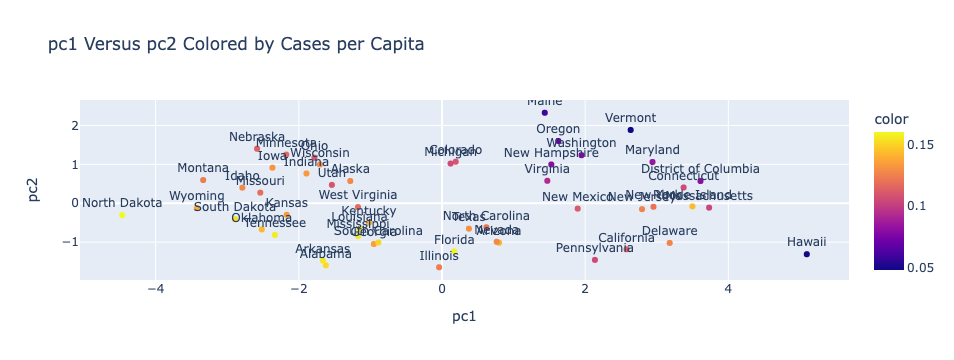

In [23]:
X_2_pcs = (X @ vt[0: 2].transpose()).rename(columns = {0 : 'pc1', 1 : 'pc2'})
X_2_pcs['color'] = Grouped["Cases per Capita"]

state_names = possibleStates
X_2_pcs['state'] = state_names 

fig = px.scatter(X_2_pcs, x="pc1", y="pc2", text="state", color = 'color',
                 title = 'pc1 Versus pc2 Colored by Cases per Capita'); 

fig.update_traces(textposition='top center');

fig.show(); 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c

What could the first and second principal component roughly represent? Interpret the visualization above and report any findings from the first two principal components given by PCA.

<!--
BEGIN QUESTION
name: q3c
points: 3
manual: True
-->

pc1 could represent the cases per capita, with high pc1 leading to lower cases per capita and low pc1 leading to more cases per capita, clear examples being North Dakota and Hawaii. pc2 could also represent, to some extent, the cases per capita, as most states with negative pc2 have high cases per capita and states with positive pc2 having lower cases per capita. At the same time, it also reflects the proportion of the population being fully vaccinated, with high pc2 representing higher proportions, as with the case of Maine and Vermont. We can observe that the red dots from the plot in 3b are states with higher cases per capita, and are clustered near the lower left corner (negative pc1 and pc2).

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3d

Construct a scree plot displaying the proportion of variance captured by each principal component.

<!--
BEGIN QUESTION
name: q3d
points: 3
manual: True
-->

''

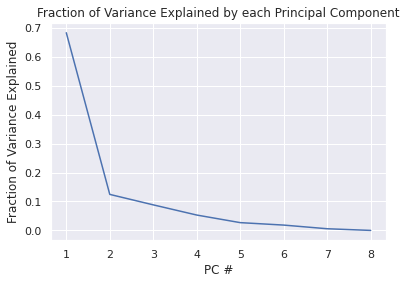

In [24]:
sns.set()
plt.plot(np.arange(1, len(s) + 1), s**2 / sum(s**2));
plt.xticks(np.arange(1, len(s) + 1), np.arange(1, len(s) + 1));
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained');
plt.title('Fraction of Variance Explained by each Principal Component')
;

<!-- END QUESTION -->

### Question 3e

Using the 2D representation of each state's first two principal components $x_i = [\text{PC}_1, \text{PC}_2]$, find each state's 5 closest principal component neighbors using Euclidean distance as the metric. In other words, for each state $i$ with first two principal components $x_i$, the following would be its *closest* principal component neighbor:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

Store each state's 5 closest neighbors in a Pandas DataFrame, where the index is the state's name and the columns are the 5 closest PC neighbors.

<!--
BEGIN QUESTION
name: q3e
points: 3
-->

In [25]:
def findclosest(data, state, number):
    state_pc1 = data.loc[data['state'] == state]['pc1'].values[0]
    state_pc2 = data.loc[data['state'] == state]['pc2'].values[0]
    temp = data
    out = np.sqrt((temp['pc1'] - state_pc1) ** 2 + (temp['pc2'] - state_pc2) ** 2)
    out = out.sort_values(ascending = True)
    return out.index[number]
    
state_mins = X_2_pcs
state_mins['closest neighbor'] = [findclosest(X_2_pcs, i, 1) for i in X_2_pcs['state'].values]
state_mins['2nd closest neighbor'] = [findclosest(X_2_pcs, i, 2) for i in X_2_pcs['state'].values]
state_mins['3rd closest neighbor'] = [findclosest(X_2_pcs, i, 3) for i in X_2_pcs['state'].values]
state_mins['4th closest neighbor'] = [findclosest(X_2_pcs, i, 4) for i in X_2_pcs['state'].values]
state_mins['5th closest neighbor'] = [findclosest(X_2_pcs, i, 5) for i in X_2_pcs['state'].values]
state_mins = state_mins[['closest neighbor', '2nd closest neighbor'
                         , '3rd closest neighbor', '4th closest neighbor', '5th closest neighbor']]
state_mins.head(10)

closest neighbor 2nd closest neighbor  \
STNAME                                                            
Alabama                           Arkansas              Georgia   
Alaska                                Utah            Wisconsin   
Arizona                             Nevada       North Carolina   
Arkansas                           Alabama          Mississippi   
California                    Pennsylvania             Delaware   
Colorado                          Michigan        New Hampshire   
Connecticut           District of Columbia         Rhode Island   
Delaware                        California           New Jersey   
District of Columbia           Connecticut         Rhode Island   
Florida                           Illinois                Texas   

                     3rd closest neighbor 4th closest neighbor  \
STNAME                                                           
Alabama                       Mississippi       South Carolina   
Alaska                            Indiana        West Virginia   
Arizona                             Texas              Florida   
Arkansas                          Georgia       South Carolina   
California                     New Jersey             New York   
Colorado                         Virginia               Oregon   
Connecticut                 Massachusetts             New York   
Delaware                         New York         Rhode Island   
District of Columbia        Massachusetts             Maryland   
Florida                            Nevada              Arizona   

                     5th closest neighbor  
STNAME                                     
Alabama                         Louisiana  
Alaska                               Ohio  
Arizona                          Illinois  
Arkansas                        Tennessee  
California                     New Mexico  
Colorado                           Alaska  
Connecticut                      Maryland  
Delaware                    Massachusetts  
District of Columbia             New York  
Florida                    North Carolina

In [26]:
grader.check("q3e")

q3e results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 3f

Investigate the principal component neighbors for two states of your choice, and remark on any observations you have about their COVID-19 statistics given in the dataset, geographical or political ties. 

Compare these neighbors with the rankings from the visualization from Question 2c that depicted recent greatest increases in cases across states.

<!--
BEGIN QUESTION
name: q3f
points: 3
manual: True
-->

In [27]:
state_mins['states'] = state_mins.index
Grouped['states'] = Grouped.index
a = Grouped.loc[Grouped['states'].isin(state_mins.loc['Alabama'])]
del state_mins['states']
a

Proportion of Fully Vaccinated  \
STNAME                                           
Alabama                               0.420403   
Arkansas                              0.451211   
Georgia                               0.446814   
Louisiana                             0.451757   
Mississippi                           0.437609   
South Carolina                        0.462500   

                Proportion of Partially Vaccinated  Cases per Capita  \
STNAME                                                                 
Alabama                                   0.101876          0.151905   
Arkansas                                  0.101725          0.155054   
Georgia                                   0.094944          0.134526   
Louisiana                                 0.064075          0.153285   
Mississippi                               0.068196          0.155155   
South Carolina                            0.079440          0.150258   

                   NEVER    RARELY  SOMETIMES  FREQUENTLY    ALWAYS  \
STNAME                                                                
Alabama         0.081567  0.081090   0.146612    0.215343  0.475313   
Arkansas        0.090920  0.087253   0.138360    0.220627  0.462867   
Georgia         0.083333  0.078377   0.126145    0.199792  0.512314   
Louisiana       0.082328  0.072453   0.114406    0.207156  0.523656   
Mississippi     0.067817  0.084488   0.119537    0.201232  0.526878   
South Carolina  0.097130  0.070543   0.109283    0.190261  0.532826   

                        states  
STNAME                          
Alabama                Alabama  
Arkansas              Arkansas  
Georgia                Georgia  
Louisiana            Louisiana  
Mississippi        Mississippi  
South Carolina  South Carolina

In [28]:
state_mins.loc['Alabama']

closest neighbor              Arkansas
2nd closest neighbor           Georgia
3rd closest neighbor       Mississippi
4th closest neighbor    South Carolina
5th closest neighbor         Louisiana
Name: Alabama, dtype: object

We can first take a look at California, its closest neighbor as calculated in Pennsylvania. Although the two states don't seem to have much geographical or political ties, their COVID-19 statistics are very similar, especially when it comes to Cases per Capita and the 'Never' category of mask use. California's second closest neighbor is Delaware, which is very similar to California in the 'Sometimes' category of mask use, at the same time, Delaware has the same political affiliation as California. California's third closest neighbour is New Jersey, and fourth closest neighbor is New York. These two states are close to each other and the other two neighbors of California as mentioned above geographically. Hence, they might have similar policies which result in close distances of pc1 and pc2. The fifth closest neighbor to California is New Mexico. Out of all 5 top neighbors, New Mexico is the one with the closest vaccination rate compared to California, both fully and partially vaccinated, and it is geographically closer to California as compared with the 4 above states.

Then, we can take a look at Alabama and its closest neighbors. The closest neighbor of Alabama is Arkansas. We can indeed observe that the two are very similar in many respects, with highly similar cases per capita and vaccination rates. In addition, the two are fairly close geographically, and both have the same political affiliation. Hence the policies of the two states might be very similar. The second closest neighbor of Alabama is Georgia, again with many similarities in the features. And the same applies for Mississippi, South Carolina, and Louisiana, Alabama’s next closest neighbors. Unlike the case with California, these states are all neighboring states geographically. Hence this may explain the neighboring of the pc1 and pc2 distances.


<!-- END QUESTION -->

### Question 3g

We will investigate the relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states. 

For the sake of simplicity, may assume that the singular geographical location of a state is given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, calculate the geographical distance and the Euclidean distance between their top 2 principal components between them. Plot the relationship where the x-axis represents the top 2 principal component distance and the y-axis represents geographical distance.

*Hint*: `geopy` has a function that can calculate distance between two pairs of latitude and longitude!

*Hint*: You should be plotting 1,275 points.

<!--
BEGIN QUESTION
name: q3g
points: 3
-->

''

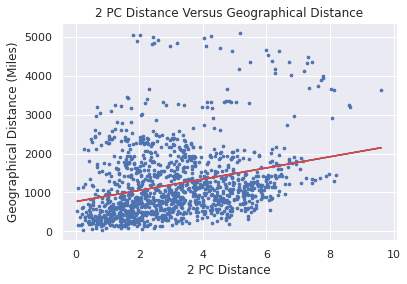

In [29]:
from geopy import distance
from geopy.distance import lonlat, distance
lat_long = county_data[['Lat', 'STNAME', 'Long_', 'CTYNAME']].groupby('STNAME').mean()
def all_combinations(data):
    out = [];
    for a in np.arange(len(data.index)):
        for b in np.arange(a, len(data.index)):
            if a != b:
                out.append([data.index[a], data.index[b]])
    return out
allcomb = all_combinations(lat_long)
def findGeoDis(alist):
    out = [];
    for ele in alist:
        Lat1 = lat_long.loc[ele[0]][0]
        Long1 = lat_long.loc[ele[0]][1]
        Lat2 = lat_long.loc[ele[1]][0]
        Long2 = lat_long.loc[ele[1]][1]
        loc1 = (Long1, Lat1)
        loc2 = (Long2, Lat2)
        dis = distance(lonlat(*loc1), lonlat(*loc2)).miles
        out.append(dis)
    return out
def findPcDis(alist):
    out = [];
    for ele in alist:
        pc1_1 = X_2_pcs.loc[ele[0]][0]
        pc2_1 = X_2_pcs.loc[ele[0]][1]
        pc1_2 = X_2_pcs.loc[ele[1]][0]
        pc2_2 = X_2_pcs.loc[ele[1]][1]
        dis = np.sqrt((pc1_1 - pc1_2) ** 2 + (pc2_1 - pc2_2) ** 2)
        out.append(dis)
    return out

x, y = findPcDis(allcomb), findGeoDis(allcomb)

plt.scatter(x, y, s = 7)
plt.title("2 PC Distance Versus Geographical Distance")
plt.xlabel('2 PC Distance')
plt.ylabel('Geographical Distance (Miles)')
temp = np.polyfit(x, y, 1)
p = np.poly1d(temp)
plt.plot(x, p(x), 'r')
sns.set()
;

### Question 3h

Interpret the relationship displayed in part (g). What does this suggest about the role that geography plays within this dataset despite no geographical information explicitly encoded within the matrix  $X$ from part (a)?

<!--
BEGIN QUESTION
name: q3h
points: 3
-->

As we can see with the plot above, there does seem to be a positive correlation between the 2PC distance and the geological distance. As discussed in part f, this might be due to neighboring states having similar COVID policies and transportation between neighboring states facilitate the spread of the virus. However, states with longer distances may not follow this trend very closely, this might be due to some federal policies in place to prevent the spread of COVID.

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

<br/><br/><br/>

## Question 4: Open EDA

Perform EDA of your choice on the data to generate 2 visualizations. You may follow the line of investigation in the guided sections by visualizing the relationship between safety protocols and the spread of COVID-19 spatially or temporally, or you may explore other areas of your choice. 

For each visualization, make sure to address the following:

1. Address a relationship in the data concerning the spread, effect, or prevention of COVID-19 through a visualization, with at *most* one univariate data visualization. If needed, use an unsupervised learning technique such as PCA to reveal patterns within the data.
2. Comment on the visualization in terms of the distribution, trends, and patterns it shows.
3. Comment on what the visualization indicates about the data with regards to the features you may choose for a supervised learning task.

<!--
BEGIN QUESTION
name: q4
points: 30
manual: True
-->

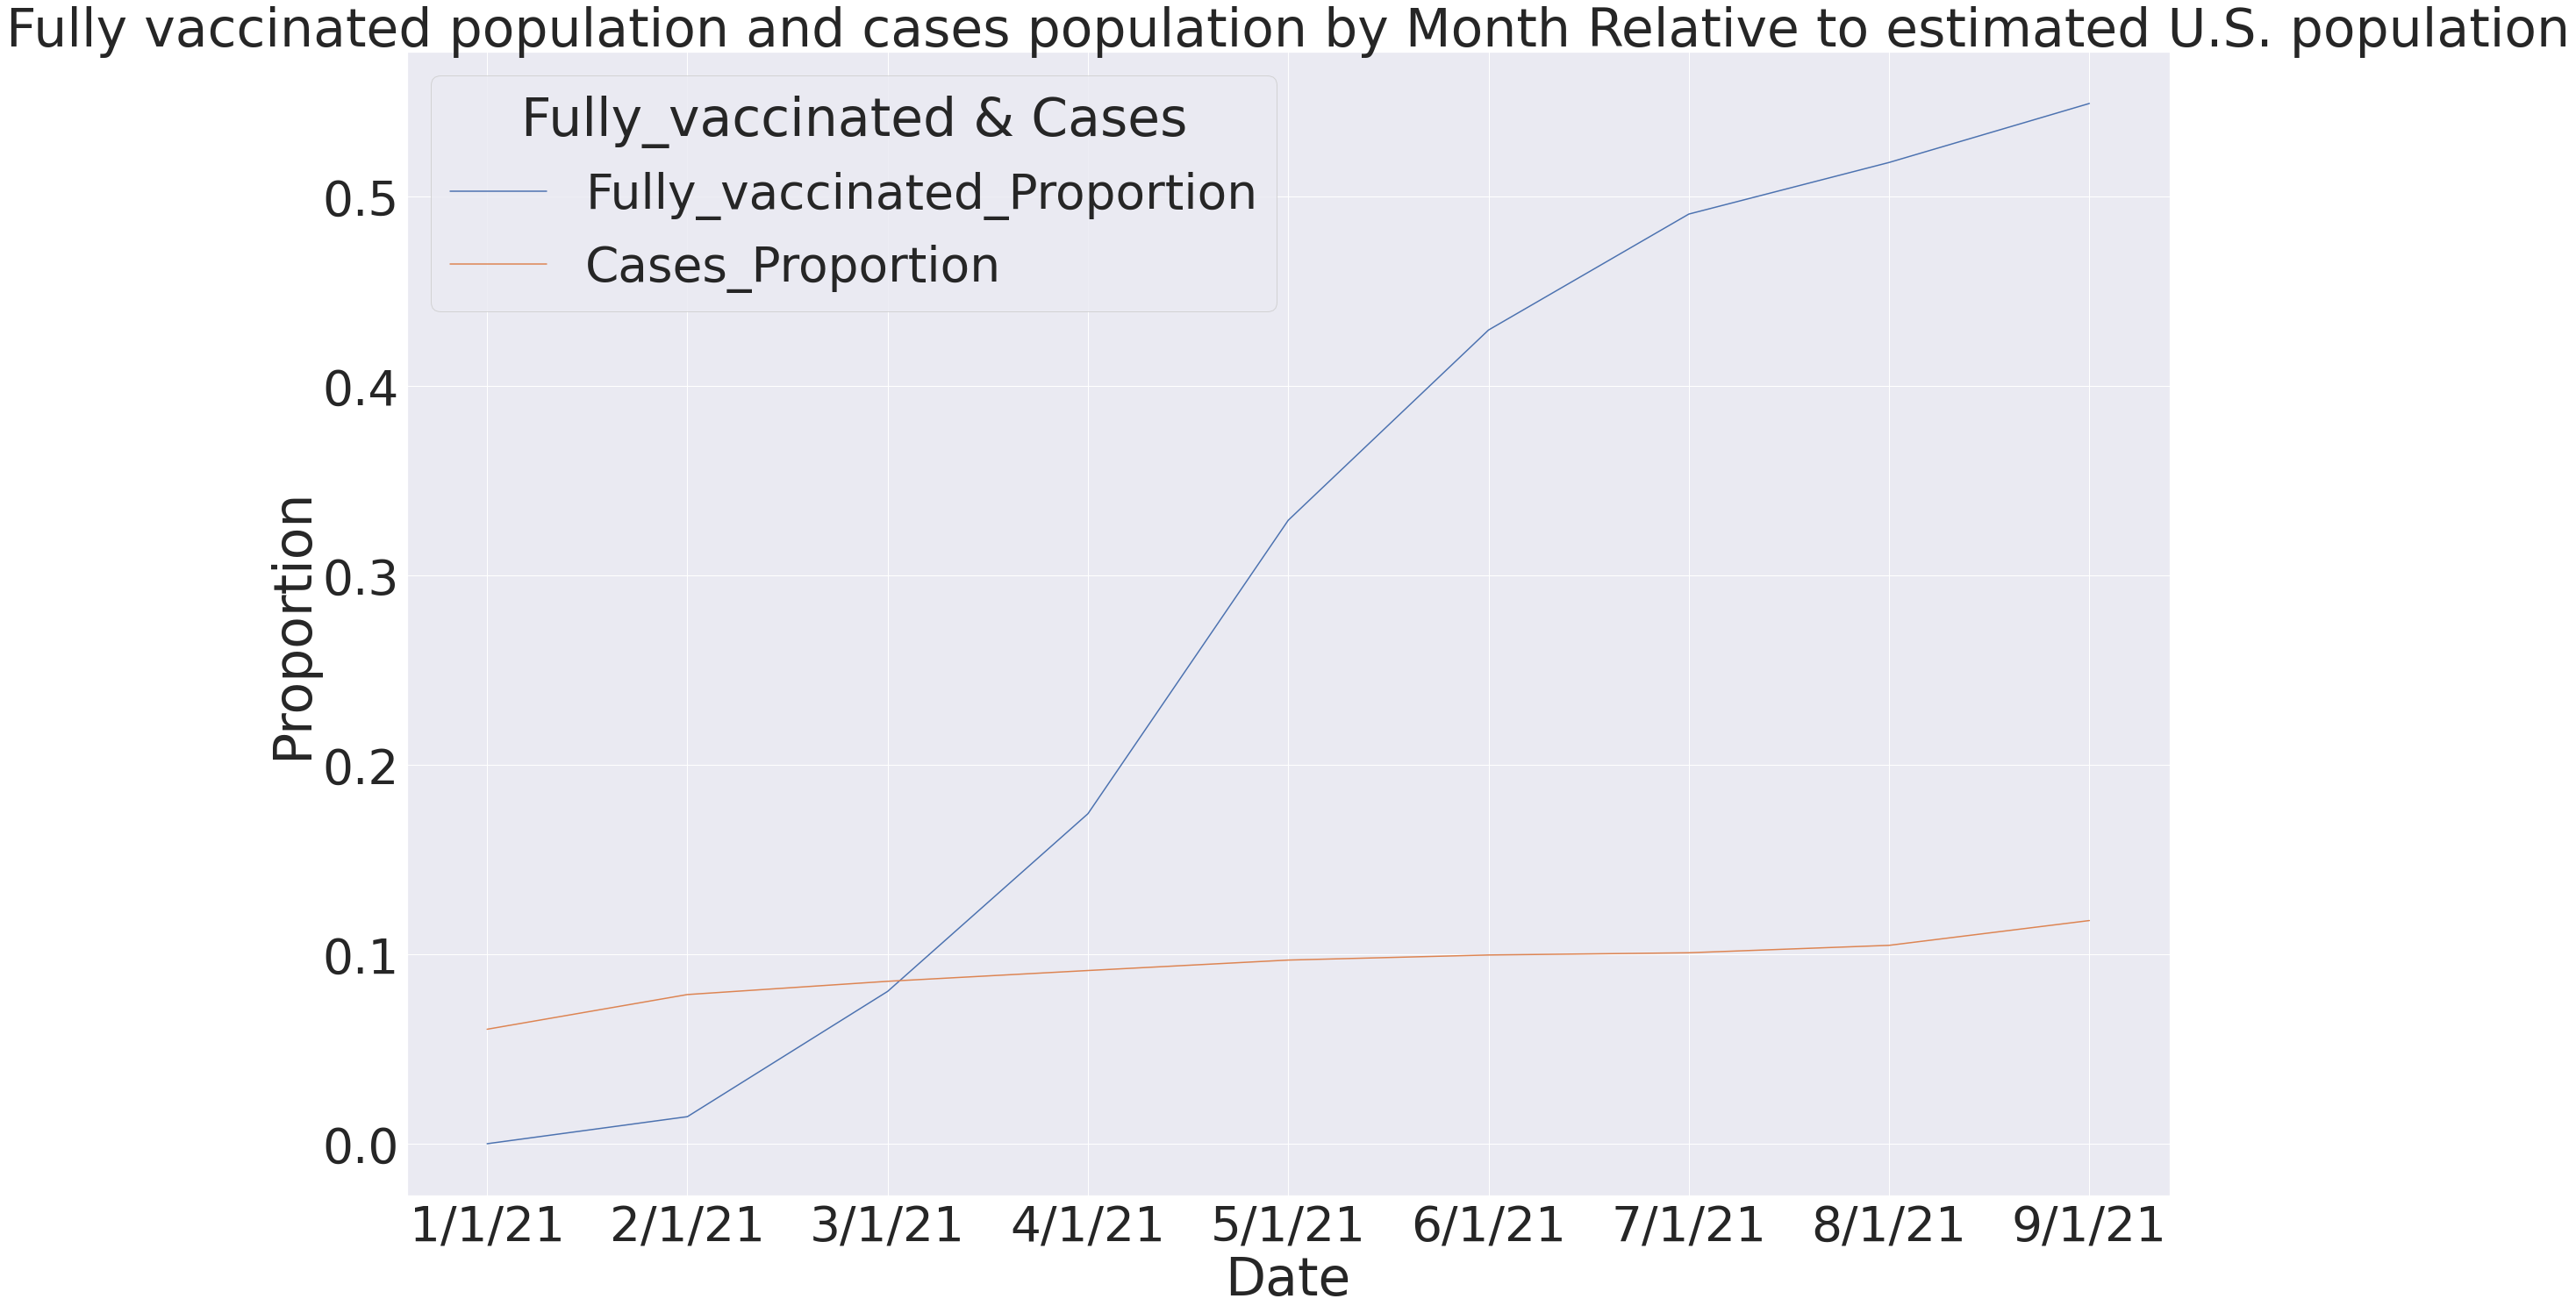

In [30]:
vac_by_date = vaccinations.groupby("Date").sum().reset_index().loc[:,["Date","People_Fully_Vaccinated"]]
list_index = list([22,53,81, 112, 142, 173, 203,234, 265])
vac_by_date = vac_by_date.iloc[list_index,:]
total_pop = county_data.groupby("STNAME").sum().sum(axis=0)["POPESTIMATE2020"]
vac_by_date["People_Fully_Vaccinated"] = vac_by_date["People_Fully_Vaccinated"]/total_pop
list_col = list([county_data.columns.get_loc("1/1/21"),county_data.columns.get_loc("2/1/21"), 
                 county_data.columns.get_loc("3/1/21"), county_data.columns.get_loc("4/1/21"),
                county_data.columns.get_loc("5/1/21"),county_data.columns.get_loc("6/1/21"),
                county_data.columns.get_loc("7/1/21"), county_data.columns.get_loc("8/1/21"),
                county_data.columns.get_loc("9/1/21")])

case_proportion=county_data.iloc[:,list_col].sum()/total_pop
monthly = pd.DataFrame({'Date': case_proportion.index, 
                        "Fully_vaccinated_Proportion": vac_by_date["People_Fully_Vaccinated"].values,
                        "Cases_Proportion": case_proportion.values})
monthly=monthly.melt("Date",var_name="Fully_vaccinated & Cases",value_name="Proportion")
sns.set(font_scale=5);
plt.figure(figsize=(36,24));
sns.lineplot(data=monthly, x="Date", y="Proportion", hue="Fully_vaccinated & Cases");
plt.title("Fully vaccinated population and cases population by Month Relative to estimated U.S. population");

Analysis: Mean monthly fully vaccinated proportion increases significantly from April to July. Therefore, it is reasonable to infer that public awareness or access of COVID vaccination takes a rise at the time period. Additionally,as the mean monthly full vaccination proportion increases, the mean monthly cases proportion is increasing at a slower rate. It indicates vaccinations are preventative of the spreading of the disease. The visualization signifies that full vaccination proportion is a predictive feature for our supervised learning task to model cases per capita. Nevertheless, there remains the possibility that other confounding variables contribute to the decreasing growth rate for cases per capita that we need to verify.

''

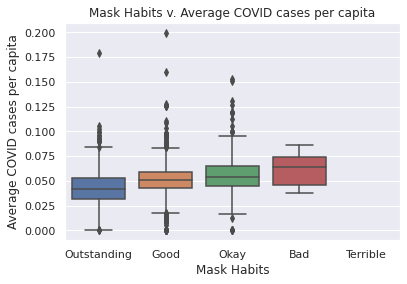

In [31]:
per_capita_cases_with_habits = county_data.loc[:,'1/22/20':'9/12/21'].div(county_data['POPESTIMATE2020'], axis=0)
per_capita_cases_with_habits['habits percentage'] = (county_data['NEVER']+county_data['RARELY']+county_data['SOMETIMES'])
per_capita_cases_with_habits['habits'] = (per_capita_cases_with_habits['habits percentage']/0.2).astype(int)
per_capita_cases_with_habits['average cases per capita'] = per_capita_cases_with_habits.loc[:,:'9/12/21'].mean(axis=1)
per_capita_cases_with_habits['habits'] = per_capita_cases_with_habits['habits'].replace([0,1,2,3,4],['Outstanding','Good','Okay','Bad','Terrible'])
sns.set(font_scale=1)
plt.title('Mask Habits v. Average COVID cases per capita')
sns.boxplot(x='habits', y='average cases per capita', data=per_capita_cases_with_habits, order = ['Outstanding', 'Good', 'Okay', 'Bad', 'Terrible'])
plt.xlabel('Mask Habits')
plt.ylabel('Average COVID cases per capita')
;

Analysis: Counties were categorized based on what proportion of their population either ‘never,’ ‘rarely,’ or ‘sometimes’ wore masks - to get specific, less than 20% was labeled as having ‘outstanding’ mask habits, down to greater than 80% as having ‘terrible’ mask habits, in intervals of 20%. As that proportion increased, so did the average COVID cases per capita, which suggests that there is a positive correlation between the proportion of the population who isn’t wearing masks and the number of cases per capita within a county. This suggests that encouraging the wearing of masks may help reduce COVID cases. It is worth noting that no county was categorized as having ‘terrible’ mask habits.

However, the spread in the data indicated there may be other factors that also play a part in determining the number of COVID cases per capita. Interestingly, the box plot seems to show more spread the greater the proportion of a county wore masks, but the counties that had poor mask-wearing habits had very little spread. This suggests that failure to wear masks may be linked to a rise in COVID cases, but wearing masks is not a guarantee that the cases per capita will be low - presumably, there are other factors that can result in a high number of COVID cases even if masks are worn.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [32]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q3e results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [33]:
# Save your notebook first, then run this cell to export your submission.
grader.export()

There was an error generating your LaTeX
Showing concise error message
[12]
! Dimension too large.
<argument> \wd \@tempboxa 
                          
l.468 ...width}{0.9\paperheight}}{output_15_1.png}
                                                  
? 
! Emergency stop.
<argument> \wd \@tempboxa 
                          
l.468 ...width}{0.9\paperheight}}{output_15_1.png}
                                                  
Output written on notebook.pdf (12 pages).
Transcript written on notebook.log.

